In [48]:
import typing as typ
from matplotlib.axes import Axes
import seaborn as sns
import numpy as np


niceblue = "#1F5B93"
nicered = "#BE533B"
nicegreen = "#54AD72"


def compute_calibration_curve(
    probabilities: list[float],
    labels: list[int],
    predictions: list[int],
    n_bins: int,
) -> tuple[list[float], list[float]]:
    """Compute the calibration curve."""
    # Create bins for probabilities
    x = [i / n_bins for i in range(n_bins + 1)]
    y = [0.0] * n_bins

    # Iterate through the bins and compute the empirical fraction
    for j in range(n_bins):
        # Select indices where probabilities fall into the current bin
        bin_indices = [idx for idx, p in enumerate(probabilities) if x[j] <= p < x[j + 1]]

        # Extract predictions and labels for the current bin
        bin_preds = [predictions[idx] for idx in bin_indices]
        bin_labels = [labels[idx] for idx in bin_indices]

        # Compute the empirical fraction (correct predictions) for the current bin
        if bin_preds:
            correct_preds = [1 if pred == label else 0 for pred, label in zip(bin_preds, bin_labels)]
            y[j] = sum(correct_preds) / len(correct_preds)
        else:
            y[j] = 0.0  # Handle empty bin case

    # Calculate midpoints of bins for x-axis
    x_centers = [(x[j] + x[j + 1]) / 2 for j in range(n_bins)]
    return x_centers, y


def plot_probability_distribution(ax: Axes, prob_true: np.ndarray, prob_false: np.ndarray, dset: str, i: int) -> None:
    # plot the distribution
    sns.kdeplot(prob_false, color=nicered, label="Incorrect", fill=True, ax=ax)
    sns.kdeplot(prob_true, color=niceblue, label="Correct", fill=True, ax=ax)
    ax.axvline(np.mean(prob_false), color=nicered, linestyle=":")
    ax.axvline(np.mean(prob_true), color=niceblue, linestyle=":")
    # ax.set_xlim(0.2, 1.2)
    ax.set_ylim(0, 2.0)
    ax.set_title(dset)
    if i == 0:
        ax.legend(loc="upper left")


def plot_calibration_curve(
    ax_cal: Axes, x: np.ndarray, y: np.ndarray, i: int, _type: typ.Literal["positive", "negative"]
) -> None:
    ax_cal.plot(x, y, color="black", marker="o", label="Calibration")
    ax_cal.plot(x, x, color="gray", linestyle=":", label="Perfectly calibrated")
    ax_cal.set_ylim(0.05, 1.0)
    ax_cal.set_xlim(0.05, 1.0)
    ax_cal.set_xlabel(r"$\max_{x}\, p(x)$")
    if i == 0:
        ax_cal.set_ylabel(f"Fraction of {_type}")
    if i == 0:
        ax_cal.legend(loc="upper left")


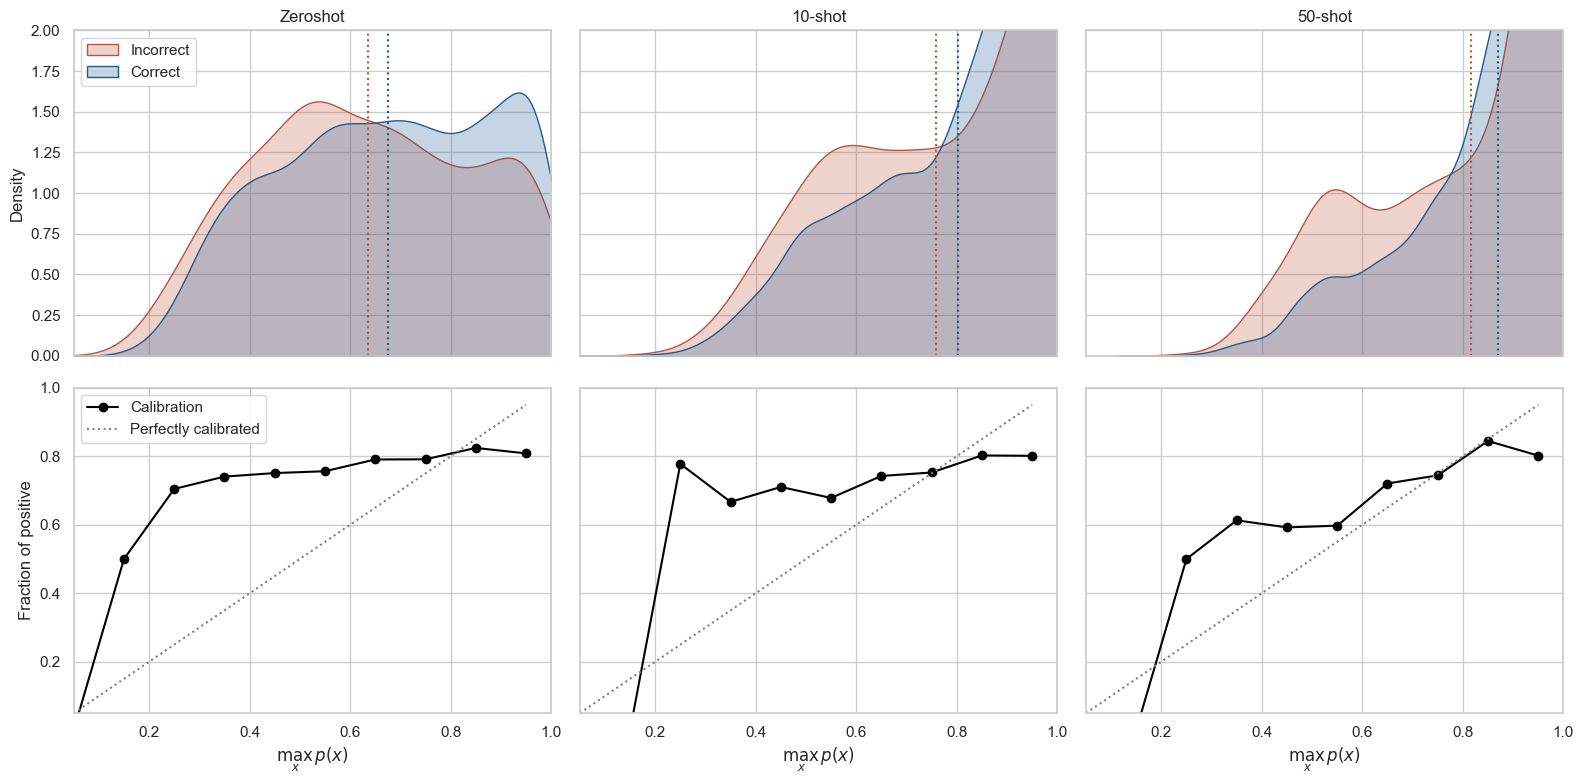

In [49]:
import json
from pathlib import Path
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

datadirs = {
    'Zeroshot': Path('/Users/amo/research/patient-note-scoring/)/Meta-Llama-3.1-70B-instruct/loft/07bd8f6f83b4c5062fe94a961e40a025/0shots/seed1'),
    '10-shot' : Path('/Users/amo/research/patient-note-scoring/)/Meta-Llama-3.1-70B-instruct/loft/6eab01c2890ee168ed9ccc7aab75767f/10shots/seed1'),
    '50-shot' : Path('/Users/amo/research/patient-note-scoring/)/Meta-Llama-3.1-70B-instruct/loft/6eab01c2890ee168ed9ccc7aab75767f/50shots/seed1')
}

n_bins = 10
niceblue = "#1F5B93"
nicered = "#BE533B"
nicegreen = "#54AD72"

def flatten_list(list_of_lists: list[list[list[float]]]) -> list[float]:
    return [item for sublist in list_of_lists for inner_list in sublist for item in inner_list]

fig, axes = plt.subplots(2, 3, figsize=(16, 8), sharey="row", sharex="col")
for i, (dset, datadir) in enumerate(datadirs.items()):
    ax = axes[0, i]
    ax_cal = axes[1, i]
    with open(datadir / 'responses.json') as f:
        data = pd.read_json(f)
    probs = data["probabilities"].to_list()
    labels = data["labels_matrix"].to_list()
    preds = data["sparse_matrix"].to_list()

    flat_probs = flatten_list(probs)
    flat_labels = flatten_list(labels)
    flat_preds = flatten_list(preds)

    # Convert labels and predictions to integers if necessary
    flat_labels = [int(y) for y in flat_labels]
    flat_preds = [int(pred) for pred in flat_preds]
    
    # get the max true and false probs
    prob_true = [prob for prob, y,y_hat in zip(flat_probs, flat_labels, flat_preds) if y==y_hat and prob>0.0]
    prob_false = [prob for prob, y,y_hat in zip(flat_probs, flat_labels, flat_preds) if y!=y_hat and prob>0.0]

    # plot the distribution
    plot_probability_distribution(ax=ax, prob_true=prob_true, prob_false=prob_false, dset=dset, i=i)

    # Extract probabilities, labels, and predictions for positive class
    probs_pos = [flat_probs[i] for i,_ in enumerate(flat_probs) if flat_probs[i] > 0.0]
    labels_pos = [flat_labels[i] for i,_ in enumerate(flat_probs) if flat_probs[i] > 0.0]
    preds_pos = [flat_preds[i] for i,_ in enumerate(flat_probs) if flat_probs[i] > 0.0]

    # Compute calibration curves for positive and negative classes
    x_pos, y_pos = compute_calibration_curve(probs_pos, labels_pos, preds_pos, n_bins)

    plot_calibration_curve(ax_cal=ax_cal, x=x_pos, y=y_pos, i=i, _type="positive")

# plt.subplots_adjust(bottom=0.2)
plt.tight_layout()
plt.savefig("uncertainty-k40.png", dpi=600)
plt.show()